# Initialisation

In [1]:
%pylab inline

import pylab

Populating the interactive namespace from numpy and matplotlib


In [105]:
import collections
import re

In [2]:
import pymongo

In [3]:
client = pymongo.MongoClient('localhost', 27017)

In [4]:
db = client.get_database('tvtropes')

In [6]:
media_collection = db.get_collection('media')
trope_collection = db.get_collection('tropes')

# Now, we look for short documents, because they might be errors, corrupted etc.

In [7]:
def line_number(document):
    return len(document['source'].split('<br>'))

In [9]:
line_numbers = [line_number(i) for i in media_collection.find()]

(array([  5.43770000e+04,   3.54800000e+03,   9.81000000e+02,
          3.85000000e+02,   1.62000000e+02,   7.10000000e+01,
          3.10000000e+01,   5.00000000e+00,   3.00000000e+00,
          1.00000000e+00]),
 array([  1.00000000e+00,   1.96400000e+02,   3.91800000e+02,
          5.87200000e+02,   7.82600000e+02,   9.78000000e+02,
          1.17340000e+03,   1.36880000e+03,   1.56420000e+03,
          1.75960000e+03,   1.95500000e+03]),
 <a list of 10 Patch objects>)

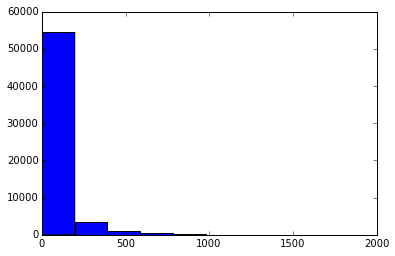

In [10]:
pylab.hist(line_numbers)

In [13]:
print(len([i for i in line_numbers if i==1]))
print(len([i for i in line_numbers if i<10]))

18311
18651


In [14]:
oneline_media = [i for i in media_collection.find() if line_number(i)==1]

In [15]:
oneline_media

[{'_id': ObjectId('56d6c7645aa9db1d53736235'),
  'modification': 1456872583.251911,
  'name': 'SnowWhite',
  'namespace': 'Disney',
  'source': '<span style="font-family:Courier, \'Courier New\', monospace">[[redirect:Disney/SnowWhiteAndTheSevenDwarfs]]</span>'},
 {'_id': ObjectId('56d6c7655aa9db1d53736239'),
  'modification': 1456872681.516101,
  'name': 'TheJungleBook2',
  'namespace': 'Disney',
  'source': '<span style="font-family:Courier, \'Courier New\', monospace">[[redirect:Disney/TheJungleBook]]</span>'},
 {'_id': ObjectId('56d6c7655aa9db1d5373623a'),
  'modification': 1456872266.0036972,
  'name': 'AGoofyMovie',
  'namespace': 'Disney',
  'source': '<span style="font-family:Courier, \'Courier New\', monospace">Couldn\'t get page source.</span>'},
 {'_id': ObjectId('56d6c7655aa9db1d5373623d'),
  'modification': 1456872461.9597518,
  'name': 'LionKing',
  'namespace': 'Disney',
  'source': '<span style="font-family:Courier, \'Courier New\', monospace">[[redirect:Disney/TheLionK

## One liners are either redirects or "Couldn't get page source". Let's count missing sources first.

In [133]:
MISSING_SOURCE_LINE = """<span style="font-family:Courier, \'Courier New\', monospace">Couldn\'t get page source.</span>"""

In [134]:
print(media_collection.find({'source': MISSING_SOURCE_LINE}).count())
missing_source = [i for i in media_collection.find({'source': MISSING_SOURCE_LINE})]

15544


In [132]:
print([(i['namespace'], i['name']) for i in missing_source])

[('Disney', 'AGoofyMovie'), ('Disney', 'Mother'), ('Disney', 'SofiaTheFirst'), ('Disney', 'ABugsLife'), ('Disney', 'TheComputerWoreTennisShoes'), ('Disney', 'Pixar'), ('Disney', 'SteamBoatWillie'), ('Disney', 'AladdinTheSeries'), ('Disney', '11473326'), ('Disney', 'BalloonFarm'), ('Disney', 'Marvel'), ('Disney', 'WallE'), ('Disney', 'Boom'), ('Disney', 'LadyAndTheTrampII'), ('Disney', 'images'), ('Disney', 'MaryPoppins1998'), ('Disney', 'protozoa'), ('Disney', 'Robin'), ('Disney', 'films'), ('Disney', 'MonstersInc'), ('Disney', 'PrincessAndTheFrog'), ('Disney', 'wdco'), ('Disney', 'non'), ('Disney', 'swan1'), ('Disney', 'Touchstone'), ('Disney', 'Walden'), ('Disney', 'SwordInTheStone'), ('Disney', 'MickeyDonaldGoofyTheThreeMusketeers'), ('Disney', 'TreasureIsland'), ('Disney', 'TheAdventuresOfMrIchabodAndMrToad'), ('Disney', 'ClassicDisneyShorts'), ('Disney', 'BedknobsAndBroomsticks'), ('Disney', 'parks'), ('Disney', 'GummiBears'), ('Disney', 'DonaldDuck'), ('Disney', 'ToyStory'), ('Di

Some are false positives from when I was searching for page titles, but some look like they are missing a proper redirect, have typos or simply point to media that are not yet described. I have no idea what to do with it at the moment.

## Now let's deal with redirects

In [116]:
def check_and_add_redirect_field(document, collection, add=True):
    source = document['source']
    if (line_number(document)==1) and ('[[redirect:' in source):
        target = source.split('redirect:')[1].split(']]')[0]
        target = target.replace('{', '').replace('}', '').replace(' ', '').replace('-', '').replace('.', '/')
        target = target.split('/')
        if len(target)==1:      # try redirecting within the same namespace
            target = [document['namespace'], target[0]]
        target_document = collection.find_one({'name': target[1], 'namespace': target[0]})
        if target_document is None:
            # try ignoring case
            target_document = collection.find_one({'name': re.compile(target[1], re.IGNORECASE), 'namespace': re.compile(target[0], re.IGNORECASE)})
            if target_document is None:
                # try in all namespaces
                try:
                    target_document = collection.find_one({'name': re.compile(target[1], re.IGNORECASE)})
                    if target_document is None:
                        return -1
                except:
                    return -1
        if add:
            collection.find_one_and_update({'_id':document['_id']}, {"$set": {'redirect': target_document['_id']}})
        return 0
    return None

In [117]:
document = media_collection.find_one({'name': 'SnowWhite', 'namespace': 'Disney'})
check_and_add_redirect_field(document, media_collection)
print(document)

{'name': 'SnowWhite', 'source': '<span style="font-family:Courier, \'Courier New\', monospace">[[redirect:Disney/SnowWhiteAndTheSevenDwarfs]]</span>', 'modification': 1456872583.251911, 'namespace': 'Disney', 'redirect': ObjectId('56d6c7675aa9db1d53736248'), '_id': ObjectId('56d6c7645aa9db1d53736235')}


In [118]:
redirect_status = [check_and_add_redirect_field(i, media_collection) for i in media_collection.find()]

In [119]:
collections.Counter(redirect_status)

Counter({None: 56803, 0: 2694, -1: 68})

In [120]:
wrong_redirect = [i for i in media_collection.find() if check_and_add_redirect_field(i, media_collection, add=False)==-1]
#print(wrong_redirect)

In [121]:
targets = [i['source'].split('redirect:')[1].split(']]')[0].replace('{', '').replace('}', '').split('/') for i in wrong_redirect]
targets.sort()
for i in targets:
    print(i)

['Anime', 'DragonBallYoSonGokuAndHisFriendsReturn']
['Anime', 'DragonBallZBioBroly']
['Anime', 'DragonBallZBojackUnbound']
['Anime', 'DragonBallZBrolySecondComing']
['Anime', 'DragonBallZTheHistoryOfTrunks']
['Anime', 'DragonBallZTheHistoryOfTrunks']
['Anime', 'DragonBallZTheTreeOfMight']
['Anime', 'DragonBallZWrathOfTheDragon']
['Anime', 'MahoGirlsPrecure']
['Anime', 'PhantasyStarOnline2TheAnimation']
['Creator', 'AliceSoft']
['Creator', 'AllisonPregler']
['Creator', 'DashiellHammett']
['Creator', 'JerryPeet']
['Creator', 'PhilFoglio']
['Creator', 'SeltzerAndFriedberg']
['Creator', 'SeltzerAndFriedberg']
['Creator', 'SeltzerAndFriedberg']
['Creator', 'SeltzerAndFriedberg']
['EmoMusic']
['FanFic', 'WhenWorldsCollideMarioSonicAndMegaManCrossover']
['Fanfic', 'Equestrylvania']
['Fanfic', 'SOE2DarkLadyOfTokyo3']
['Fanfic', 'SOETreacherousWeb']
['Film', 'Cozzilla']
['Film', 'Ghost 1990']
['Film', 'JusticeLeague2017']
['Film', 'LosCronocrimenes']
['Film', 'Malavita']
['Film', 'TheWaterHorse

In [122]:
collections.Counter(i[0] for i in targets)

Counter({'Literature': 11, 'Anime': 10, 'Creator': 9, 'VideoGame': 9, 'Film': 7, 'Manga': 4, 'Fanfic': 3, 'Series': 2, 'Wrestling': 2, 'Roleplay': 2, 'WesternAnimation': 1, 'Music': 1, 'TheHiddenEmpireSeries': 1, 'Videogame': 1, 'VisualNovel': 1, 'FanFic': 1, 'LightNovel': 1, 'EmoMusic': 1, 'Manhua': 1})

In [123]:
targets_uniq = list(set([tuple(i) for i in targets]))
targets_uniq.sort()
collections.Counter(i[0] for i in targets)

Counter({'Literature': 11, 'Anime': 10, 'Creator': 9, 'VideoGame': 9, 'Film': 7, 'Manga': 4, 'Fanfic': 3, 'Series': 2, 'Wrestling': 2, 'Roleplay': 2, 'WesternAnimation': 1, 'Music': 1, 'TheHiddenEmpireSeries': 1, 'Videogame': 1, 'VisualNovel': 1, 'FanFic': 1, 'LightNovel': 1, 'EmoMusic': 1, 'Manhua': 1})

We have 68 unresolved redirects. 9 are for Creators. I'll leave the remaining 59 as they are.

There are 18311 one-liners. 15544 are missing sources, 2762 are redirects, leaving us with 5 other pages.

In [141]:
strange_oneliners = list(media_collection.find({'$and': [{'source': {'$not': re.compile('<br>')}}, {'source': {'$not': re.compile('redirect:')}}, {'source': {'$not': {'$eq': MISSING_SOURCE_LINE}}}]}))
for i in strange_oneliners:
    print(i)

{'name': 'TheLawsOfMagic', 'namespace': 'Literature', 'source': '<span style="font-family:Courier, \'Courier New\', monospace">A GaslightFantasy series by Michael Pryor</span>', 'modification': 1456454035.8631642, '_id': ObjectId('56d6cabf5aa9db1d53737447')}
{'name': 'TrueStory', 'namespace': 'Literature', 'source': '<span style="font-family:Courier, \'Courier New\', monospace">Sam is an 11-year-old boy with Asperger\'s Syndrome who lives on a remote farm in North West England with his stressed-out mother, Alice, and his brusque father, Duncan. One day, their lives are turned upside-down when Duncan meets Larry Dougal, a Scottish hobo, at the local pub and brings him back to help them start growing cannabis. Alice is exasperated by Duncan\'s latest half-baked scheme, but Sam is enchanted by Larry, and Alice soon begins to fall for him too...</span>', 'modification': 1456457262.4865327, '_id': ObjectId('56d6cb845aa9db1d5373786f')}
{'name': 'FacesInTheStorm', 'namespace': 'Literature', '

They look fine, like article stubs.

If page is missing source, we might as well remove its field

In [142]:
media_collection.update_many({'source': MISSING_SOURCE_LINE}, {'$unset': {'source': ''}})

In [144]:
good_sources = media_collection.find({'$and': [{'source': {'$exists': True}}, {'redirect': {'$exists': False}}]})
good_sources = [i for i in good_sources if not ((line_number(document)==1) and ('[[redirect:' in i['source']))]

(array([  1.34010000e+04,   1.21270000e+04,   5.53700000e+03,
          3.14100000e+03,   1.84300000e+03,   1.24500000e+03,
          8.80000000e+02,   6.35000000e+02,   4.36000000e+02,
          3.52000000e+02,   3.11000000e+02,   2.24000000e+02,
          1.80000000e+02,   1.53000000e+02,   1.13000000e+02,
          9.50000000e+01,   9.60000000e+01,   8.10000000e+01,
          7.70000000e+01,   3.60000000e+01,   4.60000000e+01,
          3.40000000e+01,   2.70000000e+01,   3.10000000e+01,
          2.40000000e+01,   9.00000000e+00,   2.00000000e+01,
          2.20000000e+01,   6.00000000e+00,   1.40000000e+01,
          1.20000000e+01,   7.00000000e+00,   4.00000000e+00,
          5.00000000e+00,   3.00000000e+00,   4.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   3.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

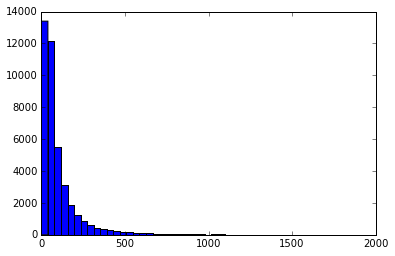

In [146]:
pylab.hist([line_number(i) for i in good_sources], bins=50)

In [148]:
len([i for i in good_sources if 1 < line_number(i) < 10])

319

In [149]:
for i in good_sources:
    if 1 < line_number(i) < 10:
        print(i)

{'name': 'GodsDemon', 'namespace': 'Literature', 'source': '<span style="font-family:Courier, \'Courier New\', monospace">\'\'God\'s Demon\'\' is a 2007 American fantasy novel by WayneBarlowe. Inspired by ChristianMythology, it tells the story of Sargatanas, a FallenAngel who participated in [[{{Satan}} Lucifer\'s]] rebellion but has since repented and now seeks {{God}}\'s forgiveness so he can return to {{Heaven}}.<br>----<br>!!This book contains examples of:<br>* DeusExMachina: When [[spoiler:Ardat Lili]] returns to life for no reason.<br>* FigureItOutYourself: God and his angels make no attempt to help the fallen ones redeem themselves, or even tell them that it is possible.<br>* LegionsOfHell<br>* RedemptionEqualsDeath: [[spoiler:Sargatanas]].<br>----</span>', 'modification': 1456445410.9101775, '_id': ObjectId('56d6c7935aa9db1d5373631d')}
{'name': 'Desiderata', 'namespace': 'Literature', 'source': '<span style="font-family:Courier, \'Courier New\', monospace">\'\'\'Desiderata\'\'\

Probably OK

## Trope pages

First, we wanted to find empty pages and remove them

In [169]:
MISSING_SOURCE_LINE_TROPES = 'Couldn\'t get page source.'
print(trope_collection.find({'source': MISSING_SOURCE_LINE_TROPES}).count())
trope_collection.delete_many({'source': MISSING_SOURCE_LINE_TROPES})

549


(array([  1.47600000e+03,   2.36000000e+03,   2.87200000e+03,
          2.39400000e+03,   1.76100000e+03,   1.29200000e+03,
          9.82000000e+02,   7.13000000e+02,   5.43000000e+02,
          4.23000000e+02,   3.04000000e+02,   2.48000000e+02,
          2.04000000e+02,   1.77000000e+02,   1.42000000e+02,
          1.25000000e+02,   9.80000000e+01,   6.90000000e+01,
          5.30000000e+01,   4.50000000e+01,   4.40000000e+01,
          3.10000000e+01,   2.60000000e+01,   2.20000000e+01,
          1.50000000e+01,   8.00000000e+00,   9.00000000e+00,
          1.10000000e+01,   6.00000000e+00,   6.00000000e+00,
          4.00000000e+00,   2.00000000e+00,   4.00000000e+00,
          2.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          2.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   3.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   1.00000000e+00,
        

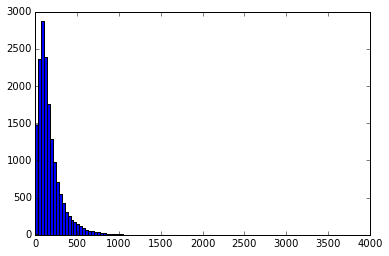

In [152]:
line_numbers = [line_number(i) for i in trope_collection.find()]
pylab.hist(line_numbers, bins=100)

In [159]:
# Tropes are a bit different
def check_and_add_redirect_field(document, add=True):
    source = document['source']
    if (line_number(document)==1) and ('[[redirect:' in source):
        target = source.split('redirect:')[1].split(']]')[0]
        target = target.replace('{', '').replace('}', '')
        target_document = trope_collection.find_one({'name': target, 'namespace': 'Main'})
        if target_document is None:
            # try ignoring case
            target_document = trope_collection.find_one({'name': re.compile(target[1], re.IGNORECASE), 'namespace': re.compile(target[0], re.IGNORECASE)})
            if target_document is None:
               return -1
        if add:
            trope_collection.find_one_and_update({'_id':document['_id']}, {"$set": {'redirect': target_document['_id']}})
        return 0
    return None

In [161]:
redirect_status = [check_and_add_redirect_field(i) for i in trope_collection.find()]
collections.Counter(redirect_status)

Counter({None: 16364, -1: 66, 0: 61})

In [162]:
wrong_redirect = [i for i in trope_collection.find() if check_and_add_redirect_field(i, add=False)==-1]
for i in wrong_redirect:
    print(i)

{'name': 'WorldInConflict', 'namespace': 'Main', 'source': '[[redirect:VideoGame/WorldInConflict]]', 'modification': 1454441816.860561, '_id': ObjectId('56d6d5565aa9db1d53744b12')}
{'name': 'NoteworthyDisneyStaff', 'namespace': 'Main', 'source': '[[redirect:Creator/NoteworthyDisneyStaff]]', 'modification': 1454278154.8941343, '_id': ObjectId('56d6d55f5aa9db1d53744bff')}
{'name': 'TheRiverWar', 'namespace': 'Main', 'source': '[[redirect:UsefulNotes/TheRiverWar]]', 'modification': 1454437613.7857022, '_id': ObjectId('56d6d5595aa9db1d53744b60')}
{'name': 'Shadow', 'namespace': 'Main', 'source': '[[redirect:ShadowArchetype]]', 'modification': 1454354695.9923966, '_id': ObjectId('56d6d5595aa9db1d53744b78')}
{'name': 'CraggyIslandFunFair', 'namespace': 'Main', 'source': '[[redirect:CrappyCarnival]]', 'modification': 1454244089.428169, '_id': ObjectId('56d6d5605aa9db1d53744c2c')}
{'name': 'MGS2Ending', 'namespace': 'Main', 'source': '[[redirect:Synopsis/MetalGearSolid2SonsOfLiberty]]', 'modif

In [163]:
targets = [i['source'].split('redirect:')[1].split(']]')[0].replace('{', '').replace('}', '').split('/') for i in wrong_redirect]
targets.sort()
for i in targets:
    print(i)

['ComicBook', 'Hawkeye']
['ComicBook', 'Wolverine']
['ComicBook', 'Wolverine']
['CrappyCarnival']
['Creator', 'CBS']
['Creator', 'Nitroplus']
['Creator', 'NoteworthyDisneyStaff']
['Creator', 'ThisTV']
['DiscussedTrope']
['FanWork']
['FanWork']
['Film', 'Amelie']
['Franchise', 'MachineRobo']
['Franchise', 'TheSlenderManMythos']
['HerosEvilPredecessor']
['HomePage']
['JustForFun', 'TheseLookLikeJobsForTheSuperman']
['Literature', 'TheSilenceOfTheLambs']
['Literature', 'WhateleyUniverse']
['LoveTropes']
['OneLetterTitle']
['OneLetterTitle']
['OneLetterTitle']
['OrangeBlueContrast']
['Reconstruction']
['Series', 'TruthOrConsequences']
['Series', 'UFO']
['Series', 'Ultraman']
['ShadowArchetype']
['SoYouWantTo', 'SeeTheIndex']
['SugarWiki', 'SuperlativeDubbing']
['Synopsis', 'MetalGearSolid2SonsOfLiberty']
['TabletopGame', 'Rifts']
['Teleportation']
['TheThreeFacesOfAdam']
['UsefulNotes', 'BigFivePersonalityTraits']
['UsefulNotes', 'EnglishCivilWar']
['UsefulNotes', 'HanoverStuartWars']
['Us

In [165]:
# most of them point to other namespaces and should be removed
for i in wrong_redirect:
    target = i['source'].split('redirect:')[1].split(']]')[0].replace('{', '').replace('}', '').split('/')
    if len(target) > 1:
        print(i)
        trope_collection.delete_one({'_id': i['_id']})

{'name': 'WorldInConflict', 'namespace': 'Main', 'source': '[[redirect:VideoGame/WorldInConflict]]', 'modification': 1454441816.860561, '_id': ObjectId('56d6d5565aa9db1d53744b12')}
{'name': 'NoteworthyDisneyStaff', 'namespace': 'Main', 'source': '[[redirect:Creator/NoteworthyDisneyStaff]]', 'modification': 1454278154.8941343, '_id': ObjectId('56d6d55f5aa9db1d53744bff')}
{'name': 'TheRiverWar', 'namespace': 'Main', 'source': '[[redirect:UsefulNotes/TheRiverWar]]', 'modification': 1454437613.7857022, '_id': ObjectId('56d6d5595aa9db1d53744b60')}
{'name': 'MGS2Ending', 'namespace': 'Main', 'source': '[[redirect:Synopsis/MetalGearSolid2SonsOfLiberty]]', 'modification': 1454257660.6152105, '_id': ObjectId('56d6d5685aa9db1d53744d11')}
{'name': 'OperationUrgentFury', 'namespace': 'Main', 'source': '[[redirect:UsefulNotes/OperationUrgentFury]]', 'modification': 1454278825.9445405, '_id': ObjectId('56d6d5765aa9db1d53744e98')}
{'name': 'TheseLookLikeJobsForTheSupermen', 'namespace': 'Main', 'sour

In [166]:
wrong_redirect = [i for i in trope_collection.find() if check_and_add_redirect_field(i, add=False)==-1]
for i in wrong_redirect:
    print(i)

{'name': 'Shadow', 'namespace': 'Main', 'source': '[[redirect:ShadowArchetype]]', 'modification': 1454354695.9923966, '_id': ObjectId('56d6d5595aa9db1d53744b78')}
{'name': 'CraggyIslandFunFair', 'namespace': 'Main', 'source': '[[redirect:CrappyCarnival]]', 'modification': 1454244089.428169, '_id': ObjectId('56d6d5605aa9db1d53744c2c')}
{'name': 'Reconstructed', 'namespace': 'Main', 'source': '[[redirect:{{Reconstruction}}]]', 'modification': 1454281318.2910903, '_id': ObjectId('56d6d56e5aa9db1d53744dc6')}
{'name': 'ThreeFacesOfAdam', 'namespace': 'Main', 'source': '[[redirect:TheThreeFacesOfAdam]]', 'modification': 1454438353.6960373, '_id': ObjectId('56d6d5765aa9db1d53744eb3')}
{'name': 'FanWorks', 'namespace': 'Main', 'source': '[[redirect:FanWork]]', 'modification': 1454247229.931633, '_id': ObjectId('56d6d5835aa9db1d53745014')}
{'name': 'JKQ6HH~G', 'namespace': 'Main', 'source': '[[redirect:OneLetterTitle]]', 'modification': 1454256067.7678642, '_id': ObjectId('56d6d5dc5aa9db1d53745

In [167]:
len(wrong_redirect)

16